# Collective inference with ABC

In [1]:
from sbi.inference import MCABC
import torch
from sbi.utils import BoxUniform
from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from simulators import wrapper, WF
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.simplefilter('ignore', Warning)


## Starting from individual inference

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

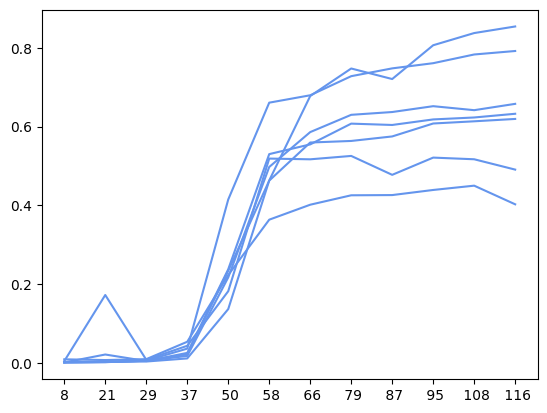

In [36]:
# Define Prior for ABC
prior = BoxUniform(low=torch.tensor([-1.5, -7, -7]), high=torch.tensor([-0.5, -3, -4]))

# Simulator and empirical data
simulator = WF
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator, prior, prior_returns_numpy)

generation = pd.read_csv('WF/empirical_data/Chuong_116_gens.txt').columns
X = pd.read_csv('WF/empirical_data/ltr.csv', index_col=0)
log_probs = []
abcs = []

# Quick inference with ABC
# Distance threshold is high because our data is very noisy
for i in range(len(X)):
    x = X.iloc[i,:]
    plt.plot(generation, x, color='cornflowerblue')
    abc = MCABC(prior=prior, simulator=simulator)
    y = abc(x_o=x, num_simulations=10000, kde=True, eps=0.5)
    log_probs.append(y.log_prob)
    abcs.append(y)

# Collective inference with the collective posterior

In [37]:
from collective_posterior import CollectivePosterior

# Define collective posterior
op = CollectivePosterior(prior, X, posterior_list=log_probs, log_C=1, epsilon=-10000, sample_var=0.05)
# Estimate log(normalizing constant)
op.get_log_C(n_reps=1)

tensor(18.2943)

In [46]:
# sample from collective posterior
samples = op.rejection_sample(100)

Rejection Sampling: 1428it [00:07, 192.30it/s]             


Text(0, 0.5, 'CNV Proportion')

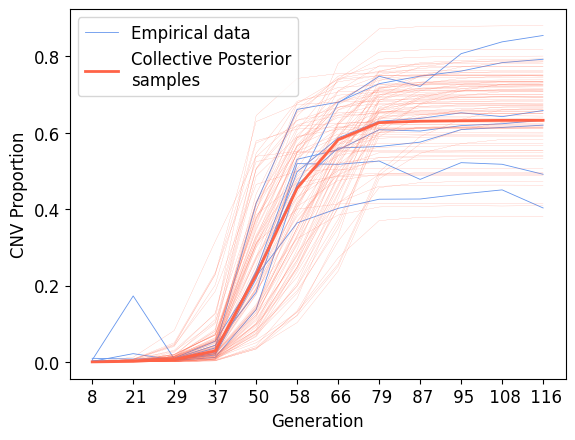

In [62]:
# Posterior predictive checks - plot simulator(samples) against data
change_font(12)
for i in range(len(X)):
    x = X.iloc[i,:]
    plt.plot(generation, x, color='cornflowerblue', lw=0.6, label = 'Empirical data' if i==0 else '')
    

for i in range(len(samples)):
    x_est = WF(samples[i])
    plt.plot(generation, x_est, color='tomato', lw=0.1)

# Highlight sample mean
plt.plot(generation, WF(samples.mean(0)), color='tomato', lw=2, label = 'Collective Posterior\nsamples')
plt.legend(loc='upper left')
plt.xlabel('Generation')
plt.ylabel('CNV Proportion')

Predictive checks look great, now let's see the marginal and pairwise posteriors

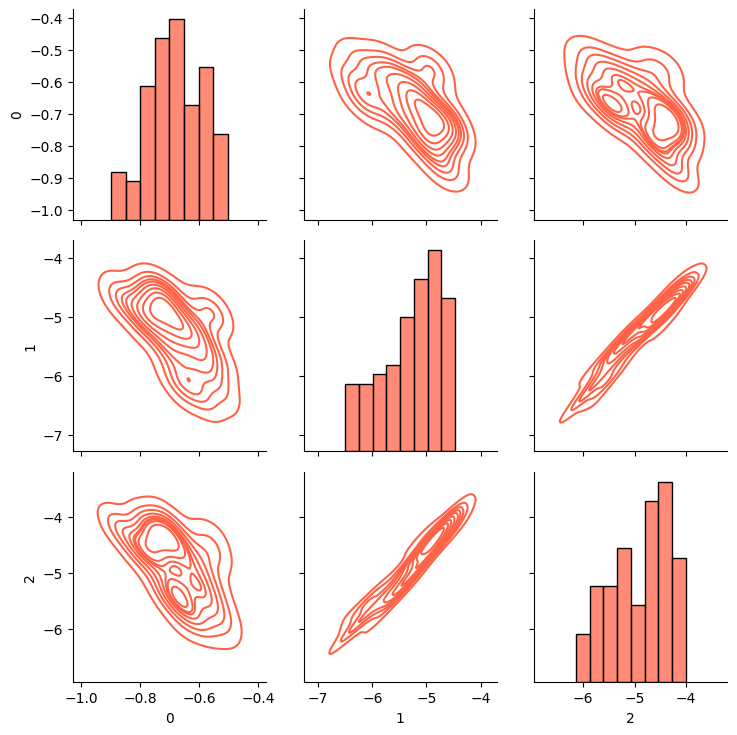

In [49]:
# visualizing with seaborn pairplot

import seaborn as sns
df = pd.DataFrame(samples.numpy())
g = sns.PairGrid(df)
g.map_upper(sns.kdeplot,color='tomato')
g.map_lower(sns.kdeplot,color='tomato')
g.map_diag(sns.histplot,color='tomato')


## Visualizing the collective marginal posteriors

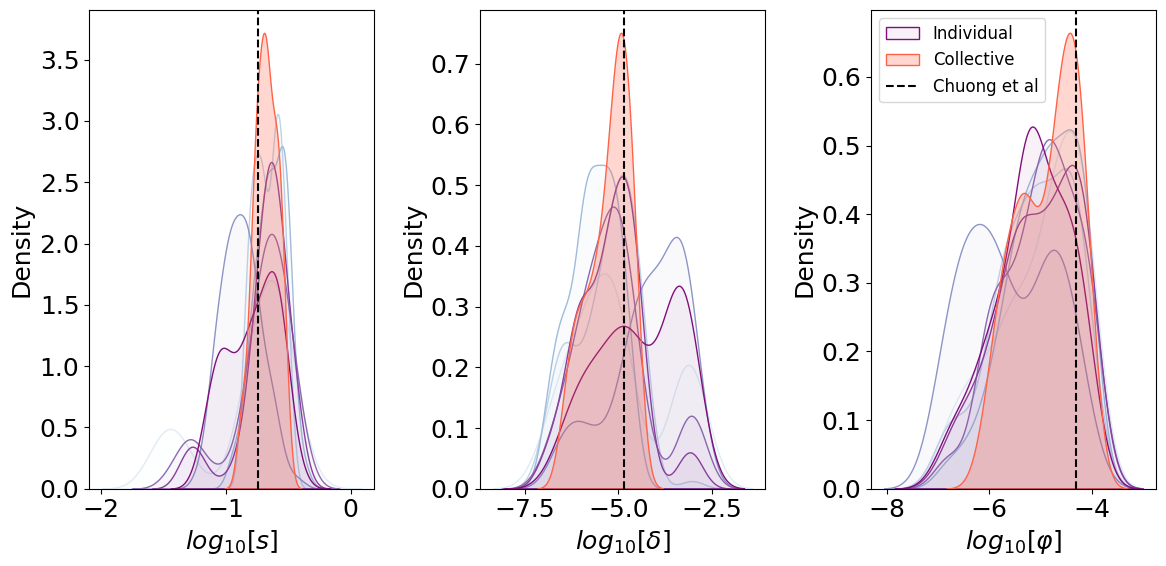

In [55]:
import matplotlib
def change_font(fontsize):
    matplotlib.rcParams['xtick.labelsize'] = fontsize
    matplotlib.rcParams['ytick.labelsize'] = fontsize
    matplotlib.rcParams['font.size'] = fontsize

change_font(18)
palette = sns.color_palette("BuPu", 7)
fig, ax = plt.subplots(1,3, tight_layout=True, figsize=(12,6))

for i in range(3):
    for j in range(len(abcs)):
        sns.kdeplot(abcs[j].sample((100,))[:,i], color=palette[j], fill=True, alpha=0.05, label='Individual' if i==2 and j==6 else '', ax=ax[i])
    sns.kdeplot(samples[:,i], color='tomato', fill=True, label='Collective' if i==2 else '', ax=ax[i])
ax[0].set_xlabel('$log_{10}[s]$')
ax[1].set_xlabel('$log_{10}[δ]$')
ax[2].set_xlabel('$log_{10}[φ]$')
ax[0].axvline(-0.74, color='k', ls='--')
ax[1].axvline(-4.84, color='k', ls='--')
ax[2].axvline(-4.32, color='k', ls='--', label='Chuong et al')
ax[2].legend(loc='upper left', fontsize=12)
